# Problem 2

In [1]:
## setup

# load libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split


# define custom data class
class WineData(Dataset):
    def __init__(self, data):
        # load dataset
        self.data = data
        self.header = self.data.columns.tolist()
        self.preds = torch.Tensor(self.data.drop("quality", axis=1).values)
        self.targets = torch.Tensor(self.data[["quality"]].values)
        
    def __len__(self):
        return len(self.preds)

    def __getitem__(self, rownum):
        preds = self.preds[rownum, :]
        target = self.targets[rownum, :]

        return preds, target
    

# load data
qual_r_raw = pd.read_csv("winequality-red.csv", delimiter=";", dtype="float")
qual_w_raw = pd.read_csv("winequality-white.csv", delimiter=";", dtype="float")

# split into training/test/validation data
qual_r_train, qual_r_other = train_test_split(qual_r_raw, train_size=0.64)
qual_r_val, qual_r_test = train_test_split(qual_r_other, train_size=0.16/(0.16+0.2))
                                           
qual_w_train, qual_w_other = train_test_split(qual_w_raw, train_size=0.64)
qual_w_val, qual_w_test = train_test_split(qual_w_other, train_size=0.16/(0.16+0.2))

# combine into final datasets
qual_train = pd.concat([qual_r_train, qual_w_train], axis=0)
qual_val = pd.concat([qual_r_val, qual_w_val], axis=0)
qual_test = pd.concat([qual_r_test, qual_w_test], axis=0)

In [2]:
# define model architecture

class WiNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.regression = nn.Sequential(
            nn.Linear(11, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.regression(x)
        return x

In [15]:
# set up model training

def train(model, train, val, epoch):
    # set up variable storing loss values, by batch/epoch    
    # set up loss function
    losses = []
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(),lr=0.0005,momentum=0, weight_decay=0)
    train_loader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=32)
    
    # loop through batches
    i = 0
    for batch_id, (train_data, train_target) in enumerate(train_loader):
        optimizer.zero_grad()
        train_output = model(train_data)
        val_output = model(val.preds)
        
        loss = criterion(train_output, train_target)
        val_loss = criterion(val_output, val.targets)
        
        loss.backward()
        optimizer.step()
        
        if batch_id == 0:
            losses = torch.Tensor([[1, batch_id, loss, val_loss]])
        else:
            losses = torch.cat((losses, torch.Tensor([[1, batch_id, loss, val_loss]])), dim=0)

        i += 1
        
    plt.plot(losses[:,1].numpy(), np.log(losses[:,2].numpy()), marker='')
    plt.plot(losses[:,1].numpy(), np.log(losses[:,3].numpy()), marker='')
    # plt.plot(losses[:,1].numpy(), losses[:,2].numpy(), marker='')
    # plt.plot(losses[:,1].numpy(), losses[:,3].numpy(), marker='')
    plt.xlabel("Batch #")
    plt.ylabel("Log-loss (MSE)")
    plt.legend(["Training loss", "Validation loss"])
    plt.title("Training loss vs. mini-batch")
    
    return losses, model, plt.gcf

WiNet(
  (regression): Sequential(
    (0): Linear(in_features=11, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)


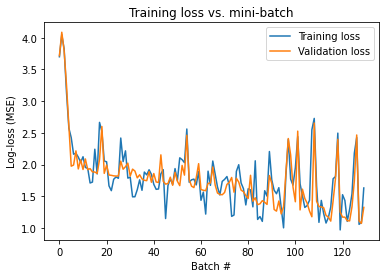

In [16]:
train_dataset = WineData(qual_train)
val_dataset = WineData(qual_val)
model =  WiNet()
epoch = 1
print(model)
losses, model_trained, plot = train(model, train_dataset, val_dataset, 1)